In [1]:
# Initializing
from google.colab import drive
import re
import math
from keras import layers
import copy

drive.mount('/content/drive')
# Define constant value
RESEARCH_WORK_PATH = "/content/drive/My Drive/Colab Notebooks/BachelorResearch/"

Mounted at /content/drive


In [2]:
"""EfficientNet V1 and V2 model configs."""

#################### EfficientNet V1 configs ####################
v1_b0_block_str = [
        'r1_k3_s1_e1_i32_o16_se0.25',
        'r2_k3_s2_e6_i16_o24_se0.25',
        'r2_k5_s2_e6_i24_o40_se0.25',
        'r3_k3_s2_e6_i40_o80_se0.25',
        'r3_k5_s1_e6_i80_o112_se0.25',
        'r4_k5_s2_e6_i112_o192_se0.25',
        'r1_k3_s1_e6_i192_o320_se0.25',
]

#################### EfficientNet V2 configs ####################
v2_base_block = [    # The baseline config for v2 models.
        'r1_k3_s1_e1_i32_o16_c1',
        'r2_k3_s2_e4_i16_o32_c1',
        'r2_k3_s2_e4_i32_o48_c1',
        'r3_k3_s2_e4_i48_o96_se0.25',
        'r5_k3_s1_e6_i96_o112_se0.25',
        'r8_k3_s2_e6_i112_o192_se0.25',
]

v2_s_block = [    # about base * (width1.4, depth1.8)
        'r2_k3_s1_e1_i24_o24_c1',
        'r4_k3_s2_e4_i24_o48_c1',
        'r4_k3_s2_e4_i48_o64_c1',
        'r6_k3_s2_e4_i64_o128_se0.25',
        'r9_k3_s1_e6_i128_o160_se0.25',
        'r15_k3_s2_e6_i160_o256_se0.25',
]


v2_m_block = [    # about base * (width1.6, depth2.2)
        'r3_k3_s1_e1_i24_o24_c1',
        'r5_k3_s2_e4_i24_o48_c1',
        'r5_k3_s2_e4_i48_o80_c1',
        'r7_k3_s2_e4_i80_o160_se0.25',
        'r14_k3_s1_e6_i160_o176_se0.25',
        'r18_k3_s2_e6_i176_o304_se0.25',
        'r5_k3_s1_e6_i304_o512_se0.25',
]


v2_l_block = [    # about base * (width2.0, depth3.1)
        'r4_k3_s1_e1_i32_o32_c1',
        'r7_k3_s2_e4_i32_o64_c1',
        'r7_k3_s2_e4_i64_o96_c1',
        'r10_k3_s2_e4_i96_o192_se0.25',
        'r19_k3_s1_e6_i192_o224_se0.25',
        'r25_k3_s2_e6_i224_o384_se0.25',
        'r7_k3_s1_e6_i384_o640_se0.25',
]

v2_xl_block = [    # only for 21k pretraining.
        'r4_k3_s1_e1_i32_o32_c1',
        'r8_k3_s2_e4_i32_o64_c1',
        'r8_k3_s2_e4_i64_o96_c1',
        'r16_k3_s2_e4_i96_o192_se0.25',
        'r24_k3_s1_e6_i192_o256_se0.25',
        'r32_k3_s2_e6_i256_o512_se0.25',
        'r8_k3_s1_e6_i512_o640_se0.25',
]
efficientnet_params = {
        # (block, width, depth, train_size, eval_size, dropout, randaug, mixup, aug)
        'efficientnetv2-s':    # 83.9% @ 22M
                (v2_s_block, 1.0, 1.0, 300, 384, 0.2, 10, 0, 'randaug'),
        'efficientnetv2-m':    # 85.2% @ 54M
                (v2_m_block, 1.0, 1.0, 384, 480, 0.3, 15, 0.2, 'randaug'),
        'efficientnetv2-l':    # 85.7% @ 120M
                (v2_l_block, 1.0, 1.0, 384, 480, 0.4, 20, 0.5, 'randaug'),

        'efficientnetv2-xl':
                (v2_xl_block, 1.0, 1.0, 384, 512, 0.4, 20, 0.5, 'randaug'),

        # For fair comparison to EfficientNetV1, using the same scaling and autoaug.
        'efficientnetv2-b0':    # 78.7% @ 7M params
                (v2_base_block, 1.0, 1.0, 192, 224, 0.2, 0, 0, 'effnetv1_autoaug'),
        'efficientnetv2-b1':    # 79.8% @ 8M params
                (v2_base_block, 1.0, 1.1, 192, 240, 0.2, 0, 0, 'effnetv1_autoaug'),
        'efficientnetv2-b2':    # 80.5% @ 10M params
                (v2_base_block, 1.1, 1.2, 208, 260, 0.3, 0, 0, 'effnetv1_autoaug'),
        'efficientnetv2-b3':    # 82.1% @ 14M params
                (v2_base_block, 1.2, 1.4, 240, 300, 0.3, 0, 0, 'effnetv1_autoaug'),

        'efficientnet-b0': (v1_b0_block_str, 1.0, 1.0, 224, 224, 0.2),
        'efficientnet-b1': (v1_b0_block_str, 1.0, 1.1, 240, 240, 0.2),
        'efficientnet-b2': (v1_b0_block_str, 1.1, 1.2, 260, 260, 0.3),
        'efficientnet-b3': (v1_b0_block_str, 1.2, 1.4, 300, 300, 0.3),
        'efficientnet-b4': (v1_b0_block_str, 1.4, 1.8, 380, 380, 0.4),
        'efficientnet-b5': (v1_b0_block_str, 1.6, 2.2, 456, 456, 0.4),
        'efficientnet-b6': (v1_b0_block_str, 1.8, 2.6, 528, 528, 0.5),
        'efficientnet-b7': (v1_b0_block_str, 2.0, 3.1, 600, 600, 0.5),
        'efficientnet-b8': (v1_b0_block_str, 2.2, 3.6, 672, 672, 0.5),
        'efficientnet-l2': (v1_b0_block_str, 4.3, 5.3, 800, 800, 0.5),
}



class Struct:
        def __init__(self, **entries):
                self.__dict__.update(entries)

def make_config(model_name):
    def round_filters(filters, multiplier, divisor, min_depth=None, skip=False):
        """Round number of filters based on depth multiplier."""
        if skip or not multiplier:
            return filters

        filters = filters*multiplier
        min_depth = min_depth or divisor
        new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
        return int(new_filters)


    def round_repeats(repeats, multiplier, skip=False):
        """Round number of filters based on depth multiplier."""
        if skip or not multiplier:
            return repeats
        return int(math.ceil(multiplier * repeats))    

    cfg = efficientnet_params[model_name]
    width_coefficient = cfg[1]
    depth_coefficient = cfg[2] 

    block_args_list = []
    for block_string in cfg[0]:
        ops = block_string.split('_')
        options = {}
        for op in ops:
            splits = re.split(r'(\d.*)', op)
            if len(splits) >= 2:
                key, value = splits[:2]
                options[key] = value

        input_filters = round_filters(int(options['i']), width_coefficient, 8)
        output_filters = round_filters(int(options['o']), width_coefficient, 8)

        block0_args =    Struct(
                kernel_size=int(options['k']),
                input_filters=input_filters,
                output_filters=output_filters,
                expand_ratio=int(options['e']),
                se_ratio=float(options['se']) if 'se' in options else 0.0,
                strides=int(options['s']),
                conv_type=int(options['c']) if 'c' in options else 0,
        )

        block_args_list.append(block0_args)
        repeats = round_repeats(int(options['r']), depth_coefficient)
        for _ in range(repeats - 1):
            block_args = copy.deepcopy(block0_args)
            block_args.input_filters=int(output_filters)
            block_args.strides=int(1)
            block_args_list.append(block_args)

    mconfig = Struct(
        name=model_name,
        block_args_list = block_args_list,
        train_size = cfg[3],
        eval_size = cfg[4],
        dropout_rate = cfg[5],
        num_classes = 4,  # changed 1000 to 4
        feature_size = round_filters( 1280, width_coefficient, 8),
        depth_divisor = 8,
        bn_momentum = 0.9,
        bn_epsilon = 1e-3,
        min_depth = 8,
        survival_prob = 0.8,
        weight_decay = 0.0,
        stem_stride=2,

    )
    return mconfig

In [3]:
def conv_kernel_initializer(shape, dtype=None, partition_info=None):
    del partition_info
    kernel_height, kernel_width, _, out_filters = shape
    fan_out = int(kernel_height * kernel_width * out_filters)
    return tf.random.normal(
            shape, mean=0.0, stddev=np.sqrt(2.0 / fan_out), dtype=dtype)

def dense_kernel_initializer(shape, dtype=None, partition_info=None):
    del partition_info
    init_range = 1.0 / np.sqrt(shape[1])
    return tf.random.uniform(shape, -init_range, init_range, dtype=dtype)

def create_efficientnet(config, input_shape=(None,None,3) , name=None, verbose=0):
    mconfig = config
    BN_KWARGS = {'momentum':mconfig.bn_momentum, 'epsilon':mconfig.bn_epsilon}
    CONV_KWARGS = {'use_bias':False, 'padding':'same', 
                    'kernel_initializer': conv_kernel_initializer, 
                    'kernel_regularizer': tf.keras.regularizers.l2(mconfig.weight_decay)}

    def activation(fn='silu', name=None):
        if fn=='sigmoid':
            return layers.Lambda( lambda y: tf.sigmoid(y), name=name)
        return layers.Lambda( lambda y: tf.nn.silu(y), name=name)

    def conv_bn_act(x, filters, kernel, stride, prefix):
        x = layers.Conv2D( filters, kernel, stride, name=prefix+'_conv2d',    **CONV_KWARGS)(x)
        x = layers.BatchNormalization(name=prefix+'_bnorm', **BN_KWARGS)(x)
        x = activation(name=prefix+'_act')(x)
        return x

    def se(inputs, se_filters, filters, prefix):
        SE_CONV_KWARGS = {'use_bias':True, 'padding':'same', 
                        'kernel_initializer': conv_kernel_initializer,
                        'kernel_regularizer': tf.keras.regularizers.l2(mconfig.weight_decay)}
        x = layers.Lambda(lambda y:tf.reduce_mean(y, [1, 2], keepdims=True), name=prefix+'_se_mean')(inputs)
        x = layers.Conv2D(se_filters, 1, 1, name=prefix+'_se_conv2d_s', **SE_CONV_KWARGS)(x)
        x = activation(name=prefix+'_se_act_s')(x)
        x = layers.Conv2D(filters, 1, 1, name=prefix+'_se_conv2d_e', **SE_CONV_KWARGS)(x)
        x = activation('sigmoid', name=prefix+'_se_act_e')(x)
        x = layers.Multiply(name=prefix+'_se_mult')( [x ,inputs ])
        return x

    def mb_conv(inputs, block_args, prefix):
        filters = block_args.input_filters * block_args.expand_ratio
        se_filters = int(block_args.input_filters*block_args.se_ratio)
        x = inputs
        if block_args.expand_ratio != 1:
            x = layers.Conv2D( filters, 1, 1, name=prefix+'_conv2d_expand', **CONV_KWARGS)(x)
            x = layers.BatchNormalization(name=prefix+'_bnorm_expand', **BN_KWARGS)(x)
            x = activation(name=prefix+'_act_expand')(x)

        x = layers.DepthwiseConv2D( block_args.kernel_size, block_args.strides, name=prefix+'_dwconv2d', **CONV_KWARGS)(x)
        x = layers.BatchNormalization(name=prefix+'_bnorm', **BN_KWARGS)(x)
        x = activation(name=prefix+'_act')(x)
        if se_filters!=0:
            x = se(x, se_filters, filters, prefix=prefix)
        x = layers.Conv2D( block_args.output_filters, 1, 1, name=prefix+'_conv2d_proj', **CONV_KWARGS)(x)
        x = layers.BatchNormalization(name=prefix+'_bnorm_proj', **BN_KWARGS)(x)

        return x

    def fused_mb_conv(inputs, block_args, prefix):
        filters = block_args.input_filters * block_args.expand_ratio
        se_filters = int(block_args.input_filters*block_args.se_ratio)
        x = inputs
        if block_args.expand_ratio != 1:
            x = layers.Conv2D( filters, block_args.kernel_size, block_args.strides, 
                name=prefix+'_conv2d_expand', **CONV_KWARGS)(x)
            x = layers.BatchNormalization(name=prefix+'_bnorm_expand', **BN_KWARGS)(x)
            x = activation(name=prefix+'_act_expand')(x)
            if se_filters!=0:
                x = se(x, se_filters, filters, prefix=prefix)
            x = layers.Conv2D( block_args.output_filters, 1, 1, 
                name = prefix+'_conv2d', **CONV_KWARGS )(x)
            x = layers.BatchNormalization(name=prefix+'_bnorm', **BN_KWARGS)(x)
        else:
            if se_filters!=0:
                x = se(x, se_filters, filters, prefix=prefix)
            x = layers.Conv2D( block_args.output_filters, block_args.kernel_size, block_args.strides,
                name = prefix+'_conv2d', **CONV_KWARGS )(x)
            x = layers.BatchNormalization(name=prefix+'_bnorm', **BN_KWARGS)(x)
            x = activation(name=prefix+'_act')(x) # add act if no expansion.

        return x

    # Input
    x = input = tf.keras.Input(shape=input_shape, name='input')


    # Stem
    stem_filters = mconfig.block_args_list[0].input_filters
    x = conv_bn_act(x, stem_filters , 3, mconfig.stem_stride, prefix='stem')
    if verbose!=0:
        print('stem', 3, stem_filters, mconfig.stem_stride )

    # Blocks
    for i, block_args in enumerate(mconfig.block_args_list):
        shortcut = x
        if block_args.conv_type==0:
            prefix = f'block_{i}'
            x = mb_conv(x, block_args, prefix)
        else:
            prefix = f'block_{i}_fused'
            x = fused_mb_conv(x, block_args, prefix)

        survival_prob = mconfig.survival_prob
        if block_args.strides == 1 and block_args.input_filters==block_args.output_filters:
            if survival_prob:
                # StochasticDepth
                drop_rate = 1.0 - survival_prob
                drop_rate = drop_rate * float(i+1) / len(mconfig.block_args_list)
                survival_prob = 1.0 - drop_rate
                x = layers.Dropout(rate=drop_rate, noise_shape=(None,1,1,1), name=prefix+'_stochdepth')(x)
            x = layers.Add(name=prefix+'_add')([shortcut,x])
        else:
            survival_prob = None

        if verbose!=0:
            print(i, block_args.kernel_size,block_args.input_filters, block_args.output_filters, 
                block_args.strides, block_args.expand_ratio, survival_prob    )

    # Head
    x = conv_bn_act( x,mconfig.feature_size , 1, 1, prefix='head')
    x = layers.GlobalAveragePooling2D(name='head_gap')(x)
    if mconfig.dropout_rate > 0:
        x = layers.Dropout(mconfig.dropout_rate,name='head_dropout')(x)
    output = layers.Dense(mconfig.num_classes,
            kernel_initializer = dense_kernel_initializer,
            kernel_regularizer = tf.keras.regularizers.l2(mconfig.weight_decay),
            use_bias = True, name='head_fc')(x)
    if verbose!=0:
        print('head', mconfig.feature_size, mconfig.num_classes, mconfig.dropout_rate    )

    model = tf.keras.Model(inputs=[input], outputs=[output], name=name)
    if verbose!=0:
        print('params', model.count_params())
    return model


In [4]:
import shutil
import os

if os.path.exists("/content/datas/"):
  shutil.rmtree("/content/datas/")
shutil.copytree(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/log-melspectro_img/", "/content/datas/")
data_dir = "/content/datas/"

In [5]:
# data_dir = tf.keras.utils.get_file(
#     'flower_photos',
#     'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
#     untar=True)
import tensorflow as tf
    
# get size of img
import cv2
sample = data_dir + "/Q1/Q1.MT0000040632_1.jpg"
i = cv2.imread(sample)
(img_row, img_col, c) = i.shape
    
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
batch_size = 32
dataflow_kwargs = dict(target_size=(img_row, img_col),
                       batch_size=batch_size,
                       interpolation="bilinear")


valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)
print(data_dir)

do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 2240 images belonging to 4 classes.
/content/datas/
Found 8960 images belonging to 4 classes.


In [6]:
# whether to finetune the whole model or just the top layer.
import numpy as np
num_epochs = 200 #@param {type:"integer"}

tf.keras.backend.clear_session()
config = make_config("efficientnetv2-b0")
model = create_efficientnet(config, input_shape=(img_row,img_col,3))
model.summary()

model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

hist = model.fit(
    train_generator,
    epochs=num_epochs, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 173, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv2d (Conv2D)           (None, 64, 87, 32)   864         ['input[0][0]']                  
                                                                                                  
 stem_bnorm (BatchNormalization  (None, 64, 87, 32)  128         ['stem_conv2d[0][0]']            
 )                                                                                                
                                                                                              

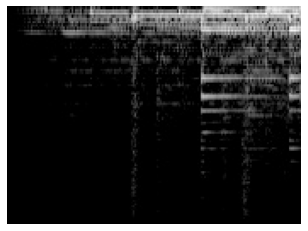

True label: Q1
Predicted label: Q3


In [7]:
from matplotlib import pyplot as plt
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

In [8]:
model.save(RESEARCH_WORK_PATH + "models/efficient_net_v2_vanilla_logmel")

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/BachelorResearch/models/efficient_net_v2_vanilla_logmel/assets


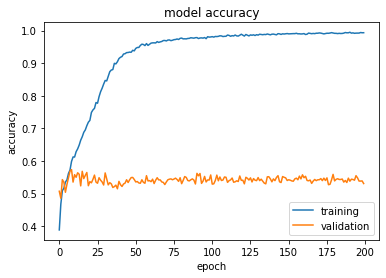

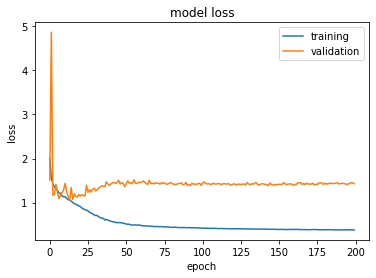

In [9]:
# 学習状況のプロット関数の定義
def plot_history(history):
    # 分類精度の履歴をプロット
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['training', 'validation'], loc='lower right')
    plt.show()

    # 損失関数の履歴をプロット
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.show()

plot_history(hist)